In [14]:
# !pip install python-binance
# !pip install python-dotenv
# !pip install pandas_ta

In [2]:
from binance.client import Client
import pandas as pd
from dotenv import load_dotenv 
import os
import pandas_ta as ta
from sklearn.preprocessing import StandardScaler

In [3]:
# --- Imports para o treinamento e backtesting ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib # Para salvar e carregar o modelo e o scaler

# --- Novo import para visualização ---
import matplotlib.pyplot as plt
import numpy as np

In [4]:
load_dotenv()

API_KEY = os.getenv("API_KEY")
API_SECRET = os.getenv("API_SECRET")

In [5]:
if not API_KEY or not API_SECRET:
    print("Erro: As chaves API_KEY ou API_SECRET não foram carregadas do arquivo .env.")
    print("Verifique se o arquivo .env existe na mesma pasta e se as variáveis estão corretas.")
    exit() # Sai do programa se as chaves não forem encontradas

# 4. Inicializa o cliente da Binance (mesmo código de antes)
try:
    client = Client(API_KEY, API_SECRET)
    print("Conexão com a Binance estabelecida com sucesso!")
except Exception as e:
    print(f"Erro ao conectar com a Binance: {e}")
    print("Verifique suas chaves de API e sua conexão com a internet.")
    exit()

# 5. Define os parâmetros para a busca dos dados de candlestick (mesmo código de antes)
symbol = 'BTCUSDT'
interval = '1h'
limit = 2500

print(f"\nBuscando os últimos {limit} candlesticks de {symbol} no intervalo de {interval}...")


Conexão com a Binance estabelecida com sucesso!

Buscando os últimos 2500 candlesticks de BTCUSDT no intervalo de 1h...


In [6]:
# 6. Faz a requisição para a API da Binance
klines = client.get_historical_klines(symbol, interval, limit=limit)


In [7]:
# 7. Processa os dados brutos e os organiza em um DataFrame do Pandas
data = []
for kline in klines:
    data.append({
        'timestamp': kline[0],
        'open': float(kline[1]),
        'high': float(kline[2]),
        'low': float(kline[3]),
        'close': float(kline[4]),
        'volume': float(kline[5])
    })

df = pd.DataFrame(data)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.set_index('timestamp', inplace=True)

# Armazenar o DataFrame original antes de renomear colunas
# para que possamos usar 'close' para o cálculo do label
df_original_cols = df.copy()

# Assegura que as colunas numéricas estão no tipo correto para pandas_ta
df.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [8]:
# --- 8. Adicionar Indicadores Técnicos (Feature Engineering) ---
print("\nAdicionando indicadores técnicos ao DataFrame...")
df.ta.sma(length=20, append=True)
df.ta.bbands(append=True)
df.ta.rsi(length=14, append=True)
print("Indicadores adicionados com sucesso!")


Adicionando indicadores técnicos ao DataFrame...
Indicadores adicionados com sucesso!


In [9]:
# --- 9 Tratamento de Valores NaN ---
print("\nTratando valores NaN...")

# Guarda o número de linhas antes de remover os NaNs
initial_rows = len(df)

# Remove todas as linhas que contêm qualquer valor NaN
df.dropna(inplace=True)

# Guarda o número de linhas depois de remover os NaNs
final_rows = len(df)

print(f"Número de linhas antes do tratamento de NaN: {initial_rows}")
print(f"Número de linhas após o tratamento de NaN: {final_rows}")
print(f"Total de linhas removidas: {initial_rows - final_rows}")


Tratando valores NaN...
Número de linhas antes do tratamento de NaN: 1000
Número de linhas após o tratamento de NaN: 981
Total de linhas removidas: 19


In [29]:
# ### **10. Normalização/Escalonamento de Dados (StandardScaler)**
# print("\nRealizando o escalonamento dos dados (StandardScaler)...")
# # Certifique-se de que todas as colunas sejam numéricas antes de escalonar
# features_to_scale = df.columns.tolist()
# # Cria uma instância do StandardScaler
# scaler = StandardScaler()
# # O resultado é um array NumPy, então o convertemos de volta para um DataFrame.
# df_scaled = pd.DataFrame(scaler.fit_transform(df[features_to_scale]),
#                          columns=features_to_scale,
#                          index=df.index)

# print("Escalonamento concluído!")


Realizando o escalonamento dos dados (StandardScaler)...
Escalonamento concluído!


In [10]:
# --- 10. Criação dos Labels (Comprar/Vender/Manter) ---
print("\nCriando os labels de Comprar/Vender/Manter...")
look_forward_period = 5
price_change_threshold = 0.005

df['future_close'] = df['Close'].shift(-look_forward_period)
df['price_change'] = (df['future_close'] - df['Close']) / df['Close']

def get_label(change, threshold):
    if change > threshold:
        return 1
    elif change < -threshold:
        return -1
    else:
        return 0

df['label'] = df['price_change'].apply(lambda x: get_label(x, price_change_threshold))

df.drop(columns=['future_close', 'price_change'], inplace=True)
df.dropna(inplace=True)
print("Labels criados com sucesso!")


Criando os labels de Comprar/Vender/Manter...
Labels criados com sucesso!


In [11]:
# 11. Dividir em Features (X) e Labels (y)
X = df.drop(columns=['label'])
y = df['label']

# Re-escalonar X e salvar o scaler
features_to_scale_final = X.columns.tolist()
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X[features_to_scale_final]),
                        columns=features_to_scale_final,
                        index=X.index)
joblib.dump(scaler, 'scaler.pkl')
print("\nScaler salvo como 'scaler.pkl' para uso em previsões futuras.")



Scaler salvo como 'scaler.pkl' para uso em previsões futuras.


In [12]:
# 12. Divisão dos Dados em Conjuntos de Treino e Teste
print("\nDividindo os dados em conjuntos de treino e teste...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=42, stratify=y)
print(f"Tamanho do conjunto de treino (X_train): {len(X_train)} linhas")
print(f"Tamanho do conjunto de teste (X_test): {len(X_test)} linhas")


Dividindo os dados em conjuntos de treino e teste...
Tamanho do conjunto de treino (X_train): 784 linhas
Tamanho do conjunto de teste (X_test): 197 linhas


In [13]:
# 13. Otimização e Treinamento do Modelo com GridSearchCV
print("\nIniciando a otimização do modelo com GridSearchCV...")
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
param_grid = {
    'n_estimators': [50, 100], # Reduzindo para agilizar o exemplo de backtesting
    'max_depth': [10, 20]
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='f1_weighted', verbose=0, n_jobs=-1) # Reduzindo cv e verbose
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
joblib.dump(best_model, 'modelo_random_forest_otimizado.pkl')
print(f"\nMelhores hiperparâmetros encontrados: {grid_search.best_params_}")
print("Treinamento e otimização concluídos. Modelo salvo como 'modelo_random_forest_otimizado.pkl'.")



Iniciando a otimização do modelo com GridSearchCV...

Melhores hiperparâmetros encontrados: {'max_depth': 10, 'n_estimators': 100}
Treinamento e otimização concluídos. Modelo salvo como 'modelo_random_forest_otimizado.pkl'.


In [14]:
# 14. Avaliação do Melhor Modelo (Revisado para usar o carregado)
print("\nCarregando modelo e scaler para avaliação e backtesting...")
loaded_scaler = joblib.load('scaler.pkl')
loaded_model = joblib.load('modelo_random_forest_otimizado.pkl')

y_pred_optimized = loaded_model.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"\nAcurácia do modelo otimizado no conjunto de teste: {accuracy_optimized:.4f}")
print("\nRelatório de Classificação do Modelo Otimizado:")
print(classification_report(y_test, y_pred_optimized))
print("\nMatriz de Confusão do Modelo Otimizado:")
cm_optimized = confusion_matrix(y_test, y_pred_optimized)
print(cm_optimized)


Carregando modelo e scaler para avaliação e backtesting...

Acurácia do modelo otimizado no conjunto de teste: 0.6650

Relatório de Classificação do Modelo Otimizado:
              precision    recall  f1-score   support

          -1       0.64      0.28      0.39        32
           0       0.71      0.88      0.78       126
           1       0.42      0.28      0.34        39

    accuracy                           0.66       197
   macro avg       0.59      0.48      0.50       197
weighted avg       0.64      0.66      0.63       197


Matriz de Confusão do Modelo Otimizado:
[[  9  20   3]
 [  3 111  12]
 [  2  26  11]]



--- Iniciando Backtesting da Estratégia com SL/TP ---
Capital inicial: 10000.00 USDT

--- Resultados do Backtest ---
Capital inicial: 10000.00 USDT
Capital final: 10552.70 USDT
Lucro/Prejuízo: 552.70 USDT
Retorno percentual: 5.53%
Número total de trades: 23
Trades Ganhadores: 12
Trades Perdedores: 11
Taxa de Acerto (Win Rate): 52.17%
Lucro Médio por Trade: 252.62 USDT
Prejuízo Médio por Trade: -205.14 USDT
Fator de Lucro: 1.34
Drawdown Máximo: -6.24%
Duração do Drawdown Máximo: -25.29 dias
Sharpe Ratio (Anualizado): 3.43
Sortino Ratio (Anualizado): 0.03


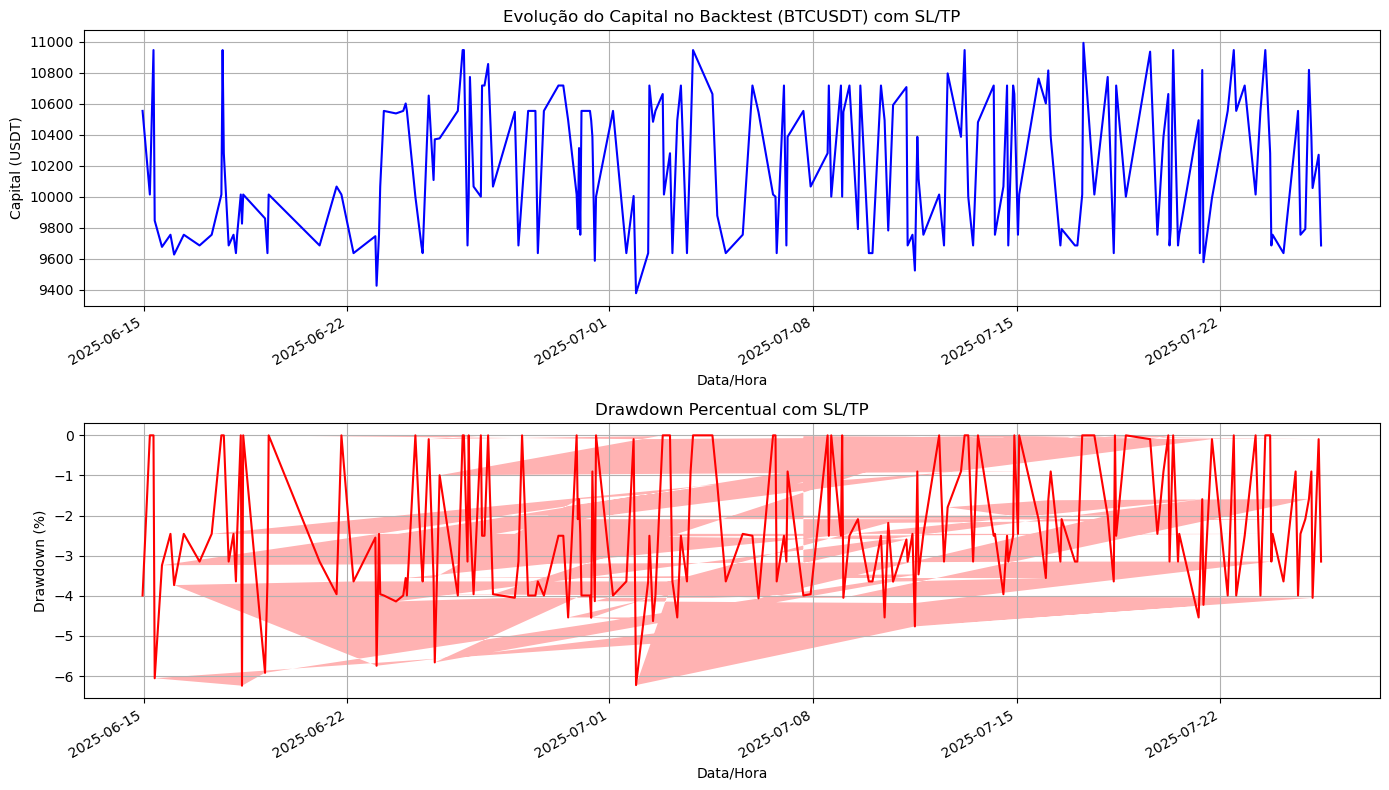


--- Backtesting com SL/TP Concluído ---


In [16]:
# --- 15. Backtesting da Estratégia com Métricas Avançadas e SL/TP ---
print("\n--- Iniciando Backtesting da Estratégia com SL/TP ---")

# Parâmetros de backtesting
initial_capital = 10000.0
position_size_percentage = 0.95
commission_rate = 0.001

# --- Novos parâmetros para Stop-Loss e Take-Profit ---
stop_loss_percent = 0.02 # 2% de perda máxima do preço de compra
take_profit_percent = 0.03 # 3% de lucro alvo do preço de compra

# Prepara os dados de teste para o backtesting
backtest_df = df.loc[X_test.index].copy()
backtest_df['predicted_label'] = y_pred_optimized
backtest_df['true_label'] = y_test

# Variáveis de controle para o backtesting
capital = initial_capital
position = 0.0
in_position = False

trade_log = []
capital_history = [initial_capital]
timestamps_history = [backtest_df.index[0]]

last_buy_price = 0.0
sl_price = 0.0
tp_price = 0.0

print(f"Capital inicial: {capital:.2f} USDT")

# Loop através dos dados do backtest candle por candle
for i, (index, row) in enumerate(backtest_df.iterrows()):
    current_open = row['Open']
    current_high = row['High']
    current_low = row['Low']
    current_close = row['Close']
    prediction = row['predicted_label']

    # --- Lógica de SAÍDA (SL/TP ou sinal de Venda) ---
    if in_position:
        # Priorizar Stop-Loss
        if current_low <= sl_price: # Se o preço mínimo do candle atingiu ou passou do SL
            exit_price = sl_price
            
            commission_cost = position * exit_price * commission_rate
            trade_pnl_usd = (exit_price - last_buy_price) * position - commission_cost
            trade_pnl_percent = (trade_pnl_usd / (last_buy_price * position)) * 100 if (last_buy_price * position) > 0 else 0

            capital += (position * exit_price) - commission_cost
            position = 0.0
            in_position = False
            
            trade_log.append({
                'timestamp_buy': trade_log[-1]['timestamp_buy'], # Assume que o último trade foi a compra
                'timestamp_sell': index,
                'type': 'SL_SELL',
                'buy_price': last_buy_price,
                'sell_price': exit_price,
                'qty': trade_log[-1]['qty'],
                'pnl_usd': trade_pnl_usd,
                'pnl_percent': trade_pnl_percent,
                'commission': commission_cost,
                'capital_after_trade': capital
            })
            # print(f"{index}: SL_SELL @ {exit_price:.2f} | Capital: {capital:.2f}")

        # Se o SL não foi atingido, verificar Take-Profit
        elif current_high >= tp_price: # Se o preço máximo do candle atingiu ou passou do TP
            exit_price = tp_price
            
            commission_cost = position * exit_price * commission_rate
            trade_pnl_usd = (exit_price - last_buy_price) * position - commission_cost
            trade_pnl_percent = (trade_pnl_usd / (last_buy_price * position)) * 100 if (last_buy_price * position) > 0 else 0

            capital += (position * exit_price) - commission_cost
            position = 0.0
            in_position = False
            
            trade_log.append({
                'timestamp_buy': trade_log[-1]['timestamp_buy'],
                'timestamp_sell': index,
                'type': 'TP_SELL',
                'buy_price': last_buy_price,
                'sell_price': exit_price,
                'qty': trade_log[-1]['qty'],
                'pnl_usd': trade_pnl_usd,
                'pnl_percent': trade_pnl_percent,
                'commission': commission_cost,
                'capital_after_trade': capital
            })
            # print(f"{index}: TP_SELL @ {exit_price:.2f} | Capital: {capital:.2f}")
        
        # Se nem SL nem TP foram atingidos, e o modelo dá sinal de venda
        elif prediction == -1 and in_position:
            # Venda normal por sinal do modelo
            commission_cost = position * current_close * commission_rate
            trade_pnl_usd = (current_close - last_buy_price) * position - commission_cost
            trade_pnl_percent = (trade_pnl_usd / (last_buy_price * position)) * 100 if (last_buy_price * position) > 0 else 0

            capital += (position * current_close) - commission_cost
            position = 0.0
            in_position = False
            
            trade_log.append({
                'timestamp_buy': trade_log[-1]['timestamp_buy'],
                'timestamp_sell': index,
                'type': 'SIGNAL_SELL',
                'buy_price': last_buy_price,
                'sell_price': current_close,
                'qty': trade_log[-1]['qty'],
                'pnl_usd': trade_pnl_usd,
                'pnl_percent': trade_pnl_percent,
                'commission': commission_cost,
                'capital_after_trade': capital
            })
            # print(f"{index}: SIGNAL_SELL @ {current_close:.2f} | Capital: {capital:.2f}")
    
    # --- Lógica de ENTRADA ---
    # Só compra se não estiver em posição e o modelo der sinal de compra
    if prediction == 1 and not in_position:
        amount_to_buy_usdt = capital * position_size_percentage
        if amount_to_buy_usdt > 0:
            qty_to_buy = amount_to_buy_usdt / current_close # Executa a compra no Close
            commission_cost = qty_to_buy * current_close * commission_rate
            
            capital -= (qty_to_buy * current_close) + commission_cost
            position += qty_to_buy
            in_position = True
            
            last_buy_price = current_close
            sl_price = last_buy_price * (1 - stop_loss_percent)
            tp_price = last_buy_price * (1 + take_profit_percent)

            trade_log.append({
                'timestamp_buy': index,
                'type': 'BUY',
                'price': current_close, # Preço de compra (Close do candle)
                'qty': qty_to_buy,
                'commission': commission_cost,
                'capital_after_trade': capital,
                'position_after_trade': position
            })
            # print(f"{index}: BUY @ {current_close:.2f} | Capital: {capital:.2f} | Pos: {position:.4f}")

    # Atualiza o histórico de capital no final de cada candle
    current_portfolio_value = capital + (position * current_close)
    capital_history.append(current_portfolio_value)
    timestamps_history.append(index)

# Calcular capital final (se ainda estiver em posição, vende no último preço)
if in_position:
    last_price = backtest_df.iloc[-1]['Close']
    commission_cost = position * last_price * commission_rate
    
    trade_pnl_usd = (last_price - last_buy_price) * position - commission_cost
    trade_pnl_percent = (trade_pnl_usd / (last_buy_price * position)) * 100 if (last_buy_price * position) > 0 else 0

    capital += (position * last_price) - commission_cost
    position = 0.0
    
    trade_log.append({
        'timestamp_buy': trade_log[-1]['timestamp_buy'] if trade_log and trade_log[-1]['type'] == 'BUY' else backtest_df.index[0], # Ultimo timestamp de BUY
        'timestamp_sell': backtest_df.index[-1],
        'type': 'FINAL_SELL',
        'buy_price': last_buy_price,
        'sell_price': last_price,
        'qty': trade_log[-1]['qty'] if trade_log else 0, # Qtde comprada (assume que a ultima entrada foi compra)
        'pnl_usd': trade_pnl_usd,
        'pnl_percent': trade_pnl_percent,
        'commission': commission_cost,
        'capital_after_trade': capital
    })
    print(f"Venda final da posição no último preço: {last_price:.2f}")

final_capital = capital
profit_loss_usd = final_capital - initial_capital
profit_loss_percent = (profit_loss_usd / initial_capital) * 100

print("\n--- Resultados do Backtest ---")
print(f"Capital inicial: {initial_capital:.2f} USDT")
print(f"Capital final: {final_capital:.2f} USDT")
print(f"Lucro/Prejuízo: {profit_loss_usd:.2f} USDT")
print(f"Retorno percentual: {profit_loss_percent:.2f}%")

# Converter trade_log para DataFrame para facilitar a análise
trade_df = pd.DataFrame(trade_log)

if not trade_df.empty and 'pnl_usd' in trade_df.columns: # Verifica se 'pnl_usd' existe para trades completos
    # Filtrar apenas os trades completos (que têm timestamp_sell) para as métricas
    complete_trades_df = trade_df[trade_df['type'].isin(['SL_SELL', 'TP_SELL', 'SIGNAL_SELL', 'FINAL_SELL'])]

    if not complete_trades_df.empty:
        # --- Métricas de Trades ---
        total_trades = len(complete_trades_df)
        winning_trades = complete_trades_df[complete_trades_df['pnl_usd'] > 0]
        losing_trades = complete_trades_df[complete_trades_df['pnl_usd'] < 0]

        num_winning_trades = len(winning_trades)
        num_losing_trades = len(losing_trades)

        win_rate = (num_winning_trades / total_trades) * 100 if total_trades > 0 else 0
        
        avg_profit_per_trade = winning_trades['pnl_usd'].mean() if num_winning_trades > 0 else 0
        avg_loss_per_trade = losing_trades['pnl_usd'].mean() if num_losing_trades > 0 else 0

        gross_profit = winning_trades['pnl_usd'].sum()
        gross_loss = abs(losing_trades['pnl_usd'].sum()) # Usar abs para o cálculo do fator de lucro

        profit_factor = gross_profit / gross_loss if gross_loss > 0 else np.inf # np.inf se não houver perdas

        print(f"Número total de trades: {total_trades}")
        print(f"Trades Ganhadores: {num_winning_trades}")
        print(f"Trades Perdedores: {num_losing_trades}")
        print(f"Taxa de Acerto (Win Rate): {win_rate:.2f}%")
        print(f"Lucro Médio por Trade: {avg_profit_per_trade:.2f} USDT")
        print(f"Prejuízo Médio por Trade: {avg_loss_per_trade:.2f} USDT")
        print(f"Fator de Lucro: {profit_factor:.2f}")
    else:
        print("Nenhum trade completo foi executado para calcular métricas detalhadas.")


    # --- Métricas de Risco e Retorno ---
    portfolio_values = pd.Series(capital_history, index=timestamps_history)
    
    returns = portfolio_values.pct_change().dropna()

    peak = portfolio_values.cummax()
    drawdown = (portfolio_values - peak) / peak
    max_drawdown = drawdown.min() * 100

    if not drawdown.empty:
        end_idx = drawdown.idxmin()
        start_idx = peak.loc[:end_idx].idxmax()
        max_drawdown_duration = (end_idx - start_idx).total_seconds() / (60 * 60 * 24)
    else:
        max_drawdown_duration = 0

    periods_per_year = 8766 # 365.25 * 24 horas

    if not returns.empty:
        sharpe_ratio_calc = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if returns.std() > 0 else np.inf
        downside_returns = returns[returns < 0]
        downside_std_dev = downside_returns.std() if not downside_returns.empty else 0
        sortino_ratio = (returns.mean() * np.sqrt(periods_per_year)) / (downside_std_dev * np.sqrt(periods_per_year)) if downside_std_dev > 0 else np.inf
    else:
        sharpe_ratio_calc = 0
        sortino_ratio = 0


    print(f"Drawdown Máximo: {max_drawdown:.2f}%")
    print(f"Duração do Drawdown Máximo: {max_drawdown_duration:.2f} dias")
    print(f"Sharpe Ratio (Anualizado): {sharpe_ratio_calc:.2f}")
    print(f"Sortino Ratio (Anualizado): {sortino_ratio:.2f}")

    # --- Visualização da Evolução do Capital e Drawdown ---
    plt.figure(figsize=(14, 8))

    plt.subplot(2, 1, 1)
    portfolio_values.plot(title=f'Evolução do Capital no Backtest ({symbol}) com SL/TP', color='blue')
    plt.xlabel('Data/Hora')
    plt.ylabel('Capital (USDT)')
    plt.grid(True)

    plt.subplot(2, 1, 2)
    (drawdown * 100).plot(title='Drawdown Percentual com SL/TP', color='red')
    plt.xlabel('Data/Hora')
    plt.ylabel('Drawdown (%)')
    plt.fill_between(drawdown.index, (drawdown * 100), 0, facecolor='red', alpha=0.3)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

else:
    print("Nenhum trade foi executado durante o backtest ou não há dados suficientes para calcular métricas.")

print("\n--- Backtesting com SL/TP Concluído ---")